In [128]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import histlite as hl
import healpy
import pickle
import socket
from numpy.random import SeedSequence, default_rng
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)
drng = default_rng()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Settings

In [129]:
selection_version = 'version-001-p01'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    plot_dir = './plotdir'
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [130]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Define Toy MC

We will create a toy MC simulation on a discrete 2D surface with coordinates x and y. 
Background will be evenly distributed on this surface.
The events will have tunable uncertainties in x- and y-direction. 
For simplicity, these will be modelled by simple independent Gaussians.
Essentially this allows us to tweak the uncertainty contours from symmetric circles to axis-aligned
elongated ellipses.
We will use this simulation to understand the importance of proper coverage as well as the impact
of circularized vs proper elliptical uncertainty contours.
In order to asses the performance in a quantitative way, we will compute the sensitivy 
(90% of trials with a test-statistic value above the median background test-statistic value) and the 3-sigma discovery potential (50% of trials with a test-statistic value above the test-statistic value corresponding to 3-sigma)
for the various settings. 
The search itself will be performed in the binned 2D space by doing the following:
 1. Convolve template with defined (estimated, i.e. not necessarily the true) uncertainty contours via a 2D convolution operation. The kernel will be the discretized Gaussian in x- and y-direction.
 2. Maximize the PS likelihood: $L(n_s) = \prod_i (\frac{n_s}{N} \cdot S_i(x_i, y_i) +  (1-\frac{n_s}{N}) \cdot B_i)$ with the signal PDF $S_i(x_i, y_i)$, defined by the convolved template and the background PDF $B_i = \frac{1}{N_\mathrm{bins}}$.
 3. Compute test-statistic $\tau = - 2 \cdot \ln \frac{L(n_s=0)}{L(\hat{n}_s)}$

In the simulation we will be able to adjust:
 - Template that we are searching for
 - True uncertainty contours: $\sigma_x$ and $\sigma_y$
 - Estimated uncertainty contours: $\hat{\sigma}_x$ and $\hat{\sigma}_y$
 - Number of bins in x-y-plane
 - Background level


#### Define simulation settings

In [205]:
from copy import deepcopy

cfg_circularized = {
    'bin_dims': (50, 40),
    'n_background': 10000,
    'cov_true': (((1, 0.), (0., 0.02))),  # true uncertainty contours
    'cov_rec':  (((0.05, 0.), (0., 0.05))),  # assumed uncertainty contours
}
cfg_perfect = deepcopy(cfg_circularized)
cfg_perfect['cov_rec'] = cfg_perfect['cov_true']

cfg_coverage = {
    'bin_dims': (50, 40),
    'n_background': 10000,
    'cov_true': (((0.05, 0.), (0., 0.05))),  # true uncertainty contours
    'cov_rec': (((0.05, 0.), (0., 0.05))),  # assumed uncertainty contours
}

cfg_dict = {
    'Rec: circularized | True: elliptical': cfg_circularized,
    'Rec: elliptical | True: elliptical': cfg_perfect,
}


# add configs for different coverages:
if False:
    for cov_factor in [0.1, 0.2, 0.5, 0.8, 1.0, 1.2, 2.0, 5., 10.]:
        cfg_i = deepcopy(cfg_coverage)
        cfg_i['cov_rec'] *= cov_factor
        cfg_dict['Coverage x {:3.2f}'.format(cov_factor)] = cfg_i

cfg_dict

{'Rec: circularized | True: elliptical': {'bin_dims': (50, 40),
  'n_background': 10000,
  'cov_true': ((1, 0.0), (0.0, 0.02)),
  'cov_rec': ((0.05, 0.0), (0.0, 0.05))},
 'Rec: elliptical | True: elliptical': {'bin_dims': (50, 40),
  'n_background': 10000,
  'cov_true': ((1, 0.0), (0.0, 0.02)),
  'cov_rec': ((1, 0.0), (0.0, 0.02))}}

#### Define helper functions for simulation

(1, 2, 2)


/tmp/ipykernel_29919/564707851.py:194: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(cf)


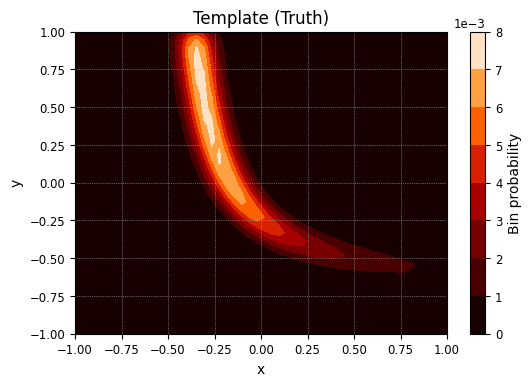

In [206]:
from scipy import signal


def multivariate_gaussian(pos, mu, cov):
    """
    Multivariate Gaussian distribution
    
    Computes the multivariate Gaussian in n-dimensional space.
    Used variables:
        N: number of samples/events
        n: number of dimensions
    
    Paramters
    ---------
    pos: array_like
        The positions in the n-dimensional space.
        Shape: [N, n]
    mu: array_like
        The center of the n-d Gaussian.
        Shape: [N, n]
    cov: array_like
        The covariance matrix.
        Shape: [N, n, n]
    
    Returns
    -------
    array_like
        The n-dimensional Gaussian evaluated at pos.
        Shape: [N] with the number of events N
    """
    n = mu.shape[0]
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    N = np.sqrt((2*np.pi)**n * cov_det)

    # This einsum call calculates (x-mu)T.cov-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,...kl,...l->...', pos-mu, cov_inv, pos-mu)

    return np.exp(-fac / 2) / N


def get_coordinates(bin_dims):
    x = np.linspace(-1, 1, bin_dims[0])
    y = np.linspace(-1, 1, bin_dims[1])
    
    X, Y = np.meshgrid(x, y)
    
    # transpose: I like to use convention: first index into array is for x, second for y
    X = X.T
    Y = Y.T
    X_flat = np.reshape(X, (-1))
    Y_flat = np.reshape(Y, (-1))
    
    return X, Y, X_flat, Y_flat


def idx_to_coordinates(x_idx, y_idx, bin_dims):
    x_mids = np.linspace(-1, 1, bin_dims[0])
    y_mids = np.linspace(-1, 1, bin_dims[1])
    
    x = x_mids[np.atleast_1d(x_idx)]
    y = y_mids[np.atleast_1d(y_idx)]
    return np.array((x, y)).T
    
def flat_idx_to_coordinates(flat_idx, bin_dims):
    x_idx, y_idx = np.unravel_index(flat_idx, shape=bin_dims)
    return idx_to_coordinates(x_idx=x_idx, y_idx=y_idx, bin_dims=bin_dims)

def coordinates_to_idx(x, y, bin_dims):
    x_mids = np.linspace(-1, 1, bin_dims[0])
    y_mids = np.linspace(-1, 1, bin_dims[1])
    
    x_diff = np.diff(x_mids)[0]
    y_diff = np.diff(y_mids)[0]
    x_edges = np.concatenate((
        np.atleast_1d(-np.inf),
        np.atleast_1d(x_mids[0] - x_diff * 0.5), 
        x_mids + x_diff * 0.5, 
        np.atleast_1d(np.inf),
    ))
    y_edges = np.concatenate((
        np.atleast_1d(-np.inf),
        np.atleast_1d(y_mids[0] - y_diff * 0.5), 
        y_mids + y_diff * 0.5, 
        np.atleast_1d(np.inf),
    ))
    x_idx = np.searchsorted(x_edges, x) - 2
    y_idx = np.searchsorted(y_edges, y) - 2
    
    mask_inbound = np.logical_and(
        x_idx >= 0,
        x_idx < len(x_mids),
    )
    mask_inbound = np.logical_and(
        mask_inbound,
        y_idx >= 0,
    )
    mask_inbound = np.logical_and(
        mask_inbound,
        y_idx < len(y_mids),
    )
    
    # compute flattened index
    idx_flat = np.atleast_1d(np.zeros_like(x, dtype=int) - 1)
    idx_flat[mask_inbound] = np.ravel_multi_index((x_idx[mask_inbound], y_idx[mask_inbound]), dims=bin_dims)
    
    return x_idx, y_idx, idx_flat

def get_template_from_gaussians(mu, cov, bin_dims):
    """Get template from multivariate Gaussian distributions
    
    Assumes x-y-plane is centered around 0 with extent -1 to 1
    in x and y.
    
    Used variables:
        N: number of samples/events
        n: number of dimensions
    
    Paramters
    ---------
    mu: array_like
        The center of the n-d Gaussian.
        Shape: [N, n]
    cov: array_like
        The covariance matrix.
        Shape: [N, n, n]
    
    Returns
    -------
    array_like
        The template PDF.
        Shape: [bin_dims_x, bin_dims_y]
    """
    X, Y, X_flat, Y_flat = get_coordinates(bin_dims)
    
    # Shape: [n_bins, 1, 2]
    pos = np.empty((np.product(bin_dims), 1, 2))
    pos[:, 0, 0] = X_flat
    pos[:, 0, 1] = Y_flat
    
    Z_flat = multivariate_gaussian(pos, mu=mu, cov=cov)
    
    # shape: [n_bins_x, n_bins_y, n_models]
    Z = np.reshape(Z_flat, (*bin_dims, len(mu)))
    
    # shape: [n_bins_x, n_bins_y]
    Z = np.sum(Z, axis=-1)
    
    # now let's normalize the PDF over the bins
    Z /= np.sum(Z)
    
    return Z
    
def get_smeared_template(template, cov, bin_dims, normalize=True):
    # make sure cov has correct shape
    # shape: [1, 2, 2]
    cov = np.asarray(cov)
    if len(cov.shape) == 2:
        cov = cov[np.newaxis]
    
    # compute discretized gaussian kernel
    unc_kernel = get_template_from_gaussians(
        mu=np.array([[0, 0]]), 
        cov=cov, 
        bin_dims=bin_dims,
    )
    smeared_template = signal.convolve(template, unc_kernel, mode='same')
    if normalize:
        smeared_template[smeared_template < 0] = 0.
        smeared_template /= np.sum(smeared_template)
    return smeared_template


def plot_template(
            template, cfg, cb_label='Bin probability', 
            only_contours=False, plot_cbar=True, fig=None, 
            ax=None, 
            **kwargs
        ):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.linspace(-1, 1, cfg['bin_dims'][0])
    y = np.linspace(-1, 1, cfg['bin_dims'][1])
    
    if only_contours:
        cf = ax.contour(x, y, np.transpose(template), **kwargs)
    else:
        cf = ax.contourf(x, y, np.transpose(template), **kwargs)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    if plot_cbar:
        cbar = fig.colorbar(cf)
        cbar.ax.set_ylabel(cb_label)

    return fig, ax


def plot_trial(template, cfg, **kwargs):
    return plot_template(template=template, cfg=cfg, cb_label='Number of Events', **kwargs)


def inject_events(cfg, n_sig, template, smearing='template', rng=drng):
    
    if smearing not in ['template', 'event']:
        raise ValueError(smearing)
        
    assert template.shape == cfg['bin_dims'], (cfg['bin_dims'], template.shape)
    
    # get background
    n_bins = np.product(cfg['bin_dims'])
    n_bkg_per_bin = cfg['n_background'] / n_bins
    bkg = rng.poisson(lam=n_bkg_per_bin, size=cfg['bin_dims'])
    
    # draw number of signal events
    n_sig = rng.poisson(lam=n_sig)
    
    # sample locations according to template
    if smearing == 'template':
        # convolve template with true uncertainty
        template_smeared = get_smeared_template(template, cov=cfg['cov_true'], bin_dims=cfg['bin_dims'])
        template = template_smeared
    
    template_flat = np.reshape(template, (-1))
    sig_idx = rng.choice(np.arange(len(template_flat)), size=n_sig, p=template_flat, replace=True)
    
    # smear location of individual events according to true uncertainty
    if smearing == 'event' and len(sig_idx) > 0:
        
        # True event locations
        # Shape: [N_events, 2]
        event_pos_true = flat_idx_to_coordinates(sig_idx, cfg['bin_dims'])
        
        # smear locations
        event_pos_reco = []
        for pos in event_pos_true:
            event_pos_reco.append(rng.multivariate_normal(mean=pos, cov=cfg['cov_true']))
        event_pos_reco = np.array(event_pos_reco)
        
        # figure out which bin idx this belongs to
        _, _, sig_idx_smeared = coordinates_to_idx(x=event_pos_reco[:, 0], y=event_pos_reco[:, 1], bin_dims=cfg['bin_dims'])
        
        # only add those that are in bounds
        sig_idx_smeared = sig_idx_smeared[sig_idx_smeared >= 0]
        
        # overwrite where to inject events
        sig_idx = sig_idx_smeared
        
    sig_idx, sig_counts = np.unique(sig_idx, return_counts=True)
    
    sig_inj = np.zeros_like(bkg)
    sig_inj_flat = np.reshape(sig_inj, (-1))
    sig_inj_flat[sig_idx] += sig_counts
    sig_inj = np.reshape(sig_inj_flat, cfg['bin_dims'])
    
    trial = bkg + sig_inj
    
    return trial, bkg, sig_inj

# ---------------
# Define Template
# ---------------
# calculate points of Gauss centers along function
x = np.linspace(-1, 1, 100)
y = 0.5*(x*2+1.5)**(-1) - .5
# y = x**2-0.5
mu = np.array([y,x]).T # flip x and y to be more elongated in y
if False:
    fix, ax = plt.subplots()
    ax.plot(y, x)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
cov = np.diag([0.005, 0.005])[np.newaxis]
print(cov.shape)
template = get_template_from_gaussians(mu, cov, bin_dims=cfg_circularized['bin_dims'])

fig, ax = plot_template(template, cfg=cfg_circularized)
ax.set_title('Template (Truth)')
fig.savefig('{}/template.png'.format(plot_dir))

# ---------------


#### Plot smeared templates

/tmp/ipykernel_29919/564707851.py:194: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(cf)


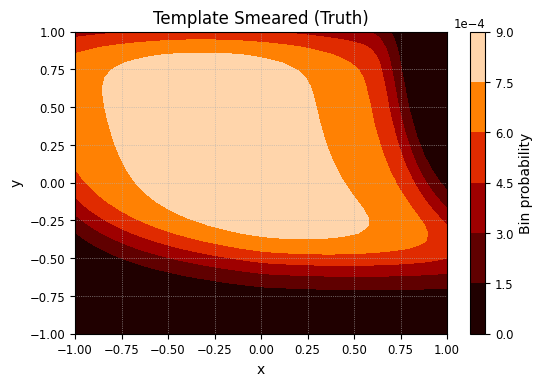

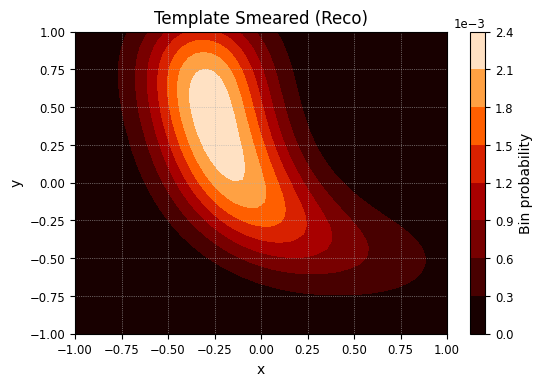

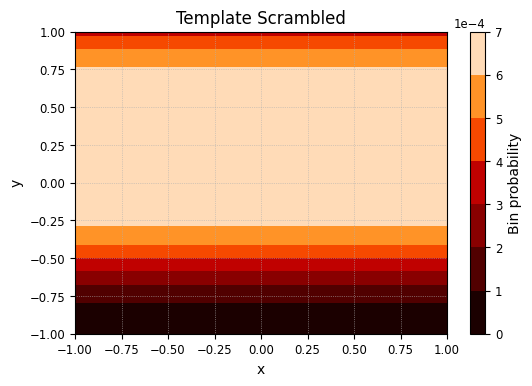

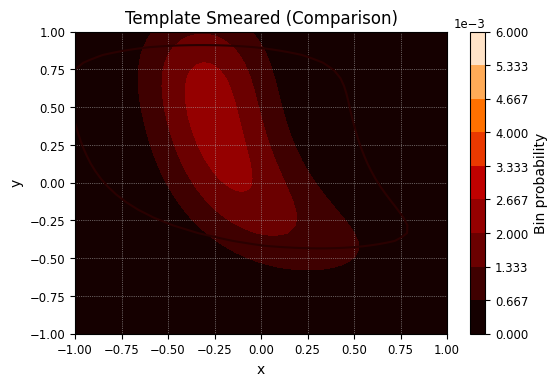

In [207]:
template_smeared_true = get_smeared_template(
    template, cov=cfg_circularized['cov_true'], bin_dims=cfg_circularized['bin_dims'])
template_smeared_rec = get_smeared_template(
    template, cov=cfg_circularized['cov_rec'], bin_dims=cfg_circularized['bin_dims'])

fig, ax = plot_template(template_smeared_true, cfg=cfg_circularized)
ax.set_title('Template Smeared (Truth)')
fig.savefig('{}/template_smeared_true.png'.format(plot_dir))

fig, ax = plot_template(template_smeared_rec, cfg=cfg_circularized)
ax.set_title('Template Smeared (Reco)')
fig.savefig('{}/template_smeared_rec.png'.format(plot_dir))

fig, ax = plot_template(template_smeared_rec.mean(axis=0)*np.ones(cfg_circularized['bin_dims']), cfg=cfg_circularized)
ax.set_title('Template Scrambled')
fig.savefig('{}/template_smeared_scram.png'.format(plot_dir))

# comparison
levels = np.linspace(0, 0.006, 10)
fig, ax = plot_template(template_smeared_rec, cfg=cfg_circularized, levels=levels)
ax.set_title('Template Smeared (Comparison)')
plot_template(template_smeared_true, cfg=cfg_circularized, only_contours=True, plot_cbar=False, fig=fig, ax=ax, levels=levels)
fig.savefig('{}/template_rec_true_comparison.png'.format(plot_dir))


In [134]:
evts, bkg, sig = inject_events(cfg=cfg_circularized, n_sig=1000, template=template)

#### Check if convolving template is equal to smearing individual events

/tmp/ipykernel_16150/1776419002.py:194: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(cf)


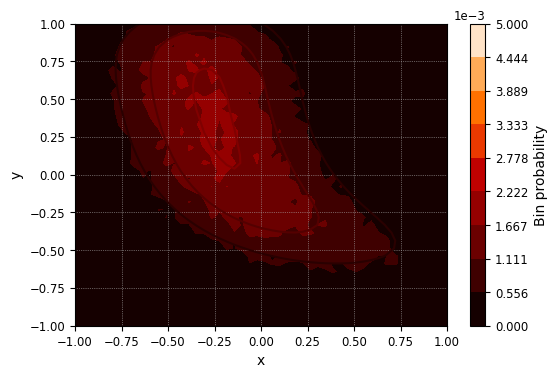

In [8]:
evts, bkg, sig = inject_events(cfg=cfg_circularized, n_sig=100000, smearing='event', template=template)

smeared_template = get_smeared_template(template, cov=cfg_circularized['cov_true'], bin_dims=cfg_circularized['bin_dims'])

levels = np.linspace(0, 0.005, 10)
fig, ax = plot_template(sig/np.sum(sig), cfg=cfg_circularized, levels=levels)
plot_template(smeared_template, cfg=cfg_circularized, only_contours=True, plot_cbar=False, fig=fig, ax=ax, levels=levels)
fig.savefig('{}/smearing_comparison.png'.format(plot_dir))


## Define Likelihood and Fit

#### Plotting Functions

In [136]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_ls_cycler(ls_list=['-', '--', ':', '-.']):
    return cycle(ls_list)

def get_color_cycler(colors=colors):
    return cycle(colors)

def plot_ns_bias(ax, ntrue, ns, label=''):
    
    ntrue = np.reshape(ntrue, (-1))
    ns = np.reshape(ns, (-1))
    
    n_sigs = np.unique(ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

    h = hl.hist((ntrue, ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$n_s$')
    ax.grid()


def plot_bkg_trials(
            bg, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$', 
            color=colors[0],
            density=False,
            bins=50,
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    if density:
        h = bg.get_hist(bins=bins).normalize()
    else:
        h = bg.get_hist(bins=bins)
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h, crosses=True, color=color, label=label)

    # compare with the chi2 fit:
    if hasattr(bg, 'pdf'):
        x = h.centers[0]
        norm = h.integrate().values
        if label_fit is not None:
            label_fit = label_fit.format(bg.ndof, bg.eta)
        if density:
            ax.semilogy(x, bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)
        else:
            ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)

    ax.set_xlabel(r'TS')
    if density:
        ax.set_ylabel(r'Density')
    else:
        ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax

#### Minimizer and Likelihood

In [135]:
from scipy.optimize import minimize
from tqdm.notebook import tqdm_notebook as tqdm
from multiprocessing import Pool


def neg_log_likelihood(ns, evts, cfg, template, sigsub=True):
        
    assert template.shape == cfg['bin_dims'], (cfg['bin_dims'], template.shape)
    
    n_events = float(np.sum(evts))
    
    # get background PDF
    n_bins = np.product(cfg['bin_dims'])
    if sigsub:
        pdf_bkg = evts.mean(axis=0)[None,:]/n_events
    else:
        pdf_bkg = 1./n_bins
    
    # convolve signal template with reconstructed uncertainty
    template_smeared = get_smeared_template(template, cov=cfg['cov_rec'], bin_dims=cfg['bin_dims'], normalize=True)
    
    # compute likelihood
    sig_term = ns/n_events * template_smeared
    if sigsub:
        bkg_term = pdf_bkg - ns/n_events * template_smeared.mean(axis=0)[None,:]
    else:
        bkg_term = (1 - ns/n_events) * pdf_bkg 
    eps = 1e-107
    llh = np.log(sig_term + bkg_term + eps) * evts
    mask = evts > 0
    llh = np.sum(llh[mask])
    
    return -llh

def fit_trial(evts, cfg, template):
    
    n_total = np.sum(evts)
    
    res = minimize(
        fun=neg_log_likelihood,
        x0=3.14,
        #bounds=[(0., n_total)],
        args=(evts, cfg, template),
    )
    return min(max(res.x[0],0), n_total)

def get_ts(evts, cfg, template):
    ns = fit_trial(evts=evts, cfg=cfg, template=template)
    neg_llh_fit = neg_log_likelihood(ns=ns, evts=evts, cfg=cfg, template=template) 
    neg_llh_h0 = neg_log_likelihood(ns=0, evts=evts, cfg=cfg, template=template) 
    ts = 2 * (neg_llh_h0 - neg_llh_fit)
    return ts, ns

def run_trial(n_sig, cfg, template, rng, scramble, evts_to_scramble=None):
    if scramble:
        assert evts_to_scramble is not None
        evts = rng.permuted(evts_to_scramble, axis=0, out=evts_to_scramble)
    else:
        evts, bkg, sig = inject_events(cfg=cfg, n_sig=n_sig, template=template, rng=rng)
    ts, ns = get_ts(evts=evts, cfg=cfg, template=template)
    return ts, ns

def _run_trial(args):
    """Wrapper for multiprocessing"""
    n_sig, cfg, template, rng, scramble, evts_to_scramble = args
    return run_trial(n_sig=n_sig, cfg=cfg, template=template, rng=rng, scramble=scramble, evts_to_scramble=evts_to_scramble)

def run_trials(n_trials, n_sig, cfg, template, seed, cpus=1, verbose=False, scramble=False):
    ns_true = np.zeros(n_trials) + n_sig
    ns = np.empty(n_trials)
    ts = np.empty(n_trials)
    ss = SeedSequence(seed)
    child_seeds = ss.generate_state(n_trials)
    streams = [default_rng(s) for s in child_seeds]
    
    if scramble:
        evts, _, _ = inject_events(cfg=cfg, n_sig=n_sig, template=template, rng=default_rng(seed))
        ts_sig, ns_sig = get_ts(evts, cfg, template)
    else:
        evts = None # generate new events for each trial
        ts_sig, ns_sig = None
    ts_sig += np.zeros(n_trials)
    ns_sig += np.zeros(n_trials)

    if cpus == 1:
        for i in tqdm(range(n_trials), total=n_trials):
            ts_i, ns_i = run_trial(n_sig=n_sig, cfg=cfg, template=template, rng=streams[i], scramble=scramble, evts_to_scramble=evts)
            ns[i] = ns_i
            ts[i] = ts_i
    else:
        args = [(n_sig, cfg, template, rng, scramble, evts) for rng in streams]
        with Pool(cpus) as p:
            if verbose:
                res = list(tqdm(p.imap(_run_trial, args), total=n_trials))
            else:
                res = p.map(_run_trial, args)
        
        res = np.array(res)
        ts[:] = res[:, 0]
        ns[:] = res[:, 1]
            
    return ts, ns, ns_true, ts_sig, ns_sig
    

In [114]:
#fit_trial(evts, cfg_circularized,template)
run_trials(100, 300, cfg_circularized, template, 1, cpus=10, scramble=True)
# evts,_,_ = inject_events(cfg=cfg_circularized, n_sig=200, template=template, seed=3)
# [run_trial(100, cfg_circularized, template, _, True,evts) for _ in range(10)]

(array([ 8.36692740e-01,  0.00000000e+00,  7.79674752e-03,  0.00000000e+00,
         3.83686216e-02,  8.94569610e-02,  0.00000000e+00,  0.00000000e+00,
         1.71125874e+00,  1.25588002e-01,  0.00000000e+00,  0.00000000e+00,
         1.74081115e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -4.90146075e-03,  4.28883506e-01,  1.12677010e-01,  0.00000000e+00,
         5.44425114e-01,  0.00000000e+00,  2.32066019e+00,  2.49321547e+00,
         5.40526354e-01, -8.03932518e-04,  6.15184206e-01,  3.41581462e-01,
         2.50933875e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.05605404e+00,  7.91432734e-01,  6.74877929e-02,  1.35281123e+00,
         0.00000000e+00,  5.11012494e-01,  5.75069307e-01,  2.66537097e-02,
         0.00000000e+00,  2.17031946e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.99657015e-02,  9.78775036e-02,  2.80891449e-01,
         0.00000000e+00,  1.20705555e+00,  4.39974458e-01,  0.00000000e+00,
         0.0

In [12]:
evts, bkg, sig = inject_events(cfg=cfg_circularized, n_sig=200, template=template)
#print(bkg)
get_ts(evts, cfg=cfg_circularized, template=template)

(5.511623225087533, array([201.60332183]))

#### Check Bias

In [13]:
seed = 0
cpus = 15
n_points = 100
n_trials = 100

res_dict = {}

for cfg_name, cfg_j in cfg_dict.items():
    n_sig_vals = np.linspace(0, 300, n_points)
    ntrue = np.empty((n_points, n_trials))
    ntrue[:] = n_sig_vals[..., np.newaxis]
    ns = np.empty((n_points, n_trials))
    ts = np.empty((n_points, n_trials))

    for i, n_sig in tqdm(enumerate(n_sig_vals), total=n_points):
        ts_i, ns_i, ns_true = run_trials(n_trials=n_trials, n_sig=n_sig, cfg=cfg_j, template=template, seed=seed, cpus=cpus)
        ns[i] = ns_i
        ts[i] = ts_i
            
    res_dict[cfg_name] = (ts, ns, ntrue)


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_16150/3623332563.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res)


  0%|          | 0/100 [00:00<?, ?it/s]

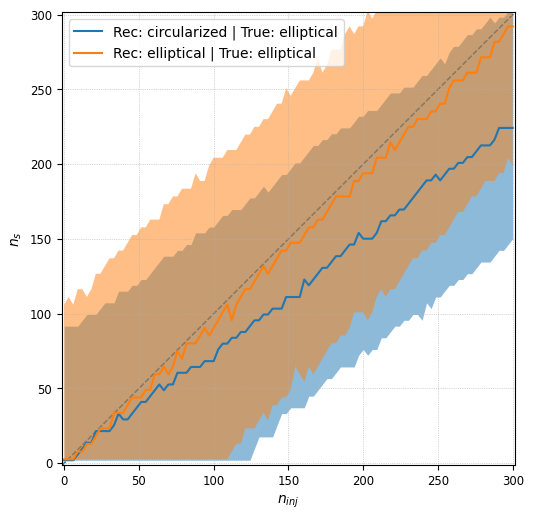

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))
for cfg_name, (ts, ns, ntrue) in res_dict.items():
    plot_ns_bias(ax=ax, ntrue=ntrue, ns=ns, label=cfg_name)
ax.legend()
fig.savefig('{}/ns_bias.png'.format(plot_dir))


#### Write Trial-Runner Wrapper to use existing csky Functionality

In [115]:
class TrialRunner(cy.trial.TrialRunner):
    
    def __init__(self, cfg, template, mp_cpus=15):
        self.cfg = cfg
        self.template = template
        self.mp_cpus = mp_cpus
    
    def get_many_fits(self, n_trials, n_sig=0, seed=0, cpus=None, verbose=False, scramble=False, **kwargs):
        
        if cpus is None:
            cpus = self.mp_cpus
            
        ts, ns, ns_true, ts_sig, ns_sig = run_trials(
            n_trials=n_trials, n_sig=n_sig, 
            cfg=self.cfg, template=self.template, 
            seed=seed, cpus=cpus, verbose=verbose,
            scramble=scramble
        )
        
        trials = cy.utils.Arrays(init={
            'ts': ts,
            'ns': ns,
            'ns_true': ns_true,
            'ts_sig': ts_sig,
            'ns_sig': ns_sig
        })
        return trials


#### Run Background Trials

In [212]:
n_trials = 1000
n_sig = 200
seed=drng.integers(10000)
#print(seed)
seed=5733
bg_dict = {}
for cfg_name, cfg in cfg_dict.items():
    tr = TrialRunner(cfg=cfg, template=template)
    trials = tr.get_many_fits(n_trials=n_trials, seed=seed, n_sig=n_sig, verbose=True, scramble=True)
    bg_dict[cfg_name] = trials

7897


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

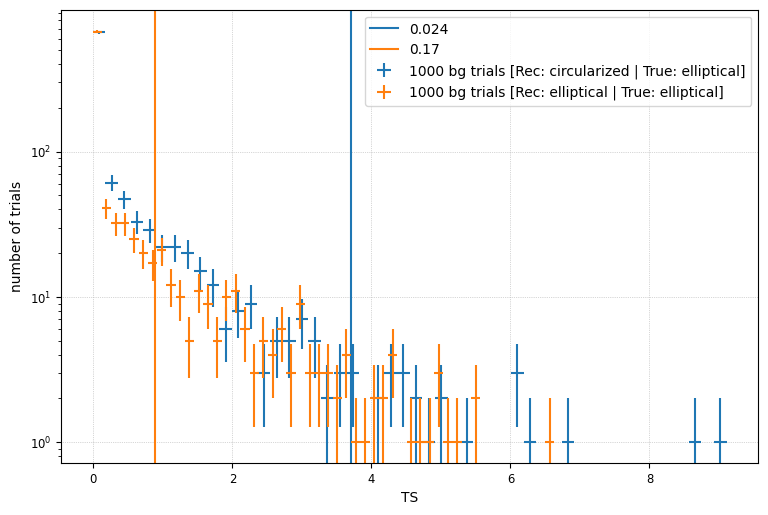

In [213]:
fig, ax = plt.subplots(figsize=(9, 6))
color_cycler = get_color_cycler()

for cfg_name, bg_trials in bg_dict.items():
    bgts = bg_trials.ts
    bg = cy.dists.TSD(values=bgts)
    color = next(color_cycler)
#     med_sg = np.median(sg_dict[cfg_name].ts)
    med_sg = np.median(bg_trials.ts_sig)
    plt.axvline(med_sg, color=color, label=f'{len(bgts[bgts>med_sg])/len(bgts)}')
    plot_bkg_trials(
        bg, fig=fig, ax=ax, 
        color=color,
        label='{} bg trials' + ' [{}]'.format(cfg_name),
    )
ax.set_yscale('log')
    

In [195]:
from collections import defaultdict
pval_dict=defaultdict(list)
ndatasets = 30
for dat in tqdm(range(ndatasets), total=ndatasets):
    for cfg_name, cfg in cfg_dict.items():
        tr = TrialRunner(cfg=cfg, template=template)
        trials = tr.get_many_fits(n_trials=n_trials, seed=dat, n_sig=n_sig, verbose=True, scramble=True)
        bgts = trials.ts
        pval_dict[cfg_name].append(len(bgts[bgts>trials.ts_sig[0]])/len(bgts))
    print(pval_dict)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168], 'Rec: elliptical | True: elliptical': [0.197]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045], 'Rec: elliptical | True: elliptical': [0.197, 0.03]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013, 0.084], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011, 0.06]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013, 0.084, 0.06], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011, 0.06, 0.062]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013, 0.084, 0.06, 0.001], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011, 0.06, 0.062, 0.0]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013, 0.084, 0.06, 0.001, 0.024], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011, 0.06, 0.062, 0.0, 0.025]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013, 0.084, 0.06, 0.001, 0.024, 0.043], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011, 0.06, 0.062, 0.0, 0.025, 0.059]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013, 0.084, 0.06, 0.001, 0.024, 0.043, 0.216], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011, 0.06, 0.062, 0.0, 0.025, 0.059, 0.161]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013, 0.084, 0.06, 0.001, 0.024, 0.043, 0.216, 0.056], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011, 0.06, 0.062, 0.0, 0.025, 0.059, 0.161, 0.047]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013, 0.084, 0.06, 0.001, 0.024, 0.043, 0.216, 0.056, 0.008], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011, 0.06, 0.062, 0.0, 0.025, 0.059, 0.161, 0.047, 0.005]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013, 0.084, 0.06, 0.001, 0.024, 0.043, 0.216, 0.056, 0.008, 0.004], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011, 0.06, 0.062, 0.0, 0.025, 0.059, 0.161, 0.047, 0.005, 0.005]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013, 0.084, 0.06, 0.001, 0.024, 0.043, 0.216, 0.056, 0.008, 0.004, 0.033], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011, 0.06, 0.062, 0.0, 0.025, 0.059, 0.161, 0.047, 0.005, 0.005, 0.059]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013, 0.084, 0.06, 0.001, 0.024, 0.043, 0.216, 0.056, 0.008, 0.004, 0.033, 0.233], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011, 0.06, 0.062, 0.0, 0.025, 0.059, 0.161, 0.047, 0.005, 0.005, 0.059, 0.278]})


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<class 'list'>, {'Rec: circularized | True: elliptical': [0.168, 0.045, 0.019, 0.236, 0.178, 0.088, 0.079, 0.475, 0.0, 0.097, 0.0, 0.005, 0.011, 0.003, 0.007, 0.002, 0.003, 0.013, 0.084, 0.06, 0.001, 0.024, 0.043, 0.216, 0.056, 0.008, 0.004, 0.033, 0.233, 0.063], 'Rec: elliptical | True: elliptical': [0.197, 0.03, 0.016, 0.285, 0.114, 0.083, 0.097, 0.475, 0.0, 0.062, 0.0, 0.005, 0.004, 0.002, 0.005, 0.0, 0.002, 0.011, 0.06, 0.062, 0.0, 0.025, 0.059, 0.161, 0.047, 0.005, 0.005, 0.059, 0.278, 0.059]})


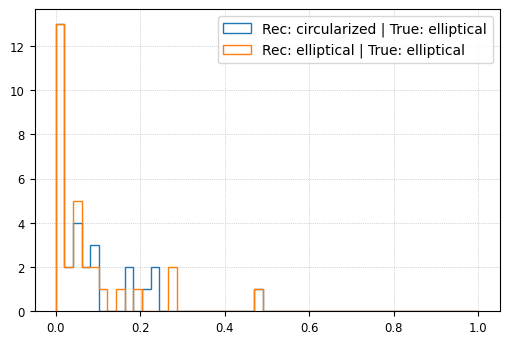

In [196]:
bins = np.linspace(0,1,50)
for cfg_name in pval_dict:
    plt.hist(pval_dict[cfg_name], bins=bins, histtype='step', label=cfg_name)
plt.legend()

#### Sensitivity and Discovery Potential

In [18]:
sens_dict = {}
bg_perfect=bg_dict['Rec: elliptical | True: elliptical']
for cfg_name, cfg in cfg_dict.items():
    print('Computing sensitivity for {}'.format(cfg_name))
    bg = cy.dists.TSD(values=bg_perfect.ts)
    ts_median = bg.median()
    print('  Median TS: {:3.3f}'.format(ts_median))
    tr = TrialRunner(cfg=cfg, template=template)
    res = tr.find_n_sig(ts=ts_median, beta=0.9, n_sig_step=5, first_batch_size=200, batch_size=2000, tol=0.03)
    
    sens_dict[cfg_name] = {
        'n_sig': res['n_sig'],
        'n_sig_error': res['n_sig_error'],
    }

Computing sensitivity for Rec: circularized | True: elliptical
  Median TS: -0.000
Start time: 2022-08-10 08:36:52.798775
Using 15 cores.
* Starting initial scan for 90% of 200 trials with TS >= -0.000...
  n_sig = 5.000 ... frac = 0.99000
* Generating batches of 2000 trials...
n_trials | n_inj    0.00    2.00    4.00    6.00    8.00   10.00  |  n_sig(relative error)
2000     |      

/tmp/ipykernel_16150/3623332563.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res)


   99.3%   99.3%   99.5%   99.0%   99.2%   99.1%  |        inf (+/-  inf%) [chi2.cdf]
4000     |         98.9%

/tmp/ipykernel_16150/3623332563.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res)


End time: 2022-08-10 08:38:01.169025
Elapsed time: 0:01:08.370250
Computing sensitivity for Rec: elliptical | True: elliptical
  Median TS: -0.000
Start time: 2022-08-10 08:38:01.172839
Using 15 cores.
* Starting initial scan for 90% of 200 trials with TS >= -0.000...
  n_sig = 5.000 ... frac = 0.98500
* Generating batches of 2000 trials...
n_trials | n_inj    0.00    2.00    4.00    6.00    8.00   10.00  |  n_sig(relative error)
2000     |         99.2%End time: 2022-08-10 08:38:17.460123
Elapsed time: 0:00:16.287284


UnboundLocalError: local variable 'info' referenced before assignment

In [ ]:
disc_dict = {}

for cfg_name, cfg in cfg_dict.items():
    print('Computing 3-sigma discovery potential for {}'.format(cfg_name))
    
    bg = cy.dists.TSD(values=bg_perfect.ts)
    ts_3sigma = bg.isf_nsigma(3)
    print('  3-sigma TS: {:3.3f}'.format(ts_3sigma))
    tr = TrialRunner(cfg=cfg, template=template)
    res = tr.find_n_sig(ts=ts_3sigma, beta=0.5, n_sig_step=10, batch_size=1000)
    
    disc_dict[cfg_name] = {
        'n_sig': res['n_sig'],
        'n_sig_error': res['n_sig_error'],
    }

#### Make plot for circularized comparison

In [ ]:
def plot_performance(ns_dict, label_suffix=''):
    color_cycler = get_color_cycler()
    
    counter = 1
    names = []
    fig, ax = plt.subplots(figsize=(9, 6))
    for cfg_name, cfg in ns_dict.items():
        if 'Coverage x' in cfg_name: 
            continue

        color = next(color_cycler)
        
        yerr = ns_dict[cfg_name]['n_sig_error'] * ns_dict[cfg_name]['n_sig']
        ax.errorbar(
            counter, ns_dict[cfg_name]['n_sig'], yerr=yerr, 
            marker='.', label=cfg_name + label_suffix, color=color,
        )
        counter += 1
        names.append(cfg_name)

    ax.legend()
    ax.set_xlim(0.5, counter - 0.5)
    ax.set_xlabel('Tested scenario')
    ax.set_xticks(range(1, counter))
    ax.set_ylabel('Signal events $n_\mathrm{inj}$')
    return fig, ax

fig, ax = plot_performance(sens_dict, label_suffix=' [sensitivity]')
fig.savefig('{}/sens_comparison_circularized.png'.format(plot_dir))
fig, ax = plot_performance(disc_dict, label_suffix=r' [$3\sigma$ disc.]')
fig.savefig('{}/disc_comparison_circularized.png'.format(plot_dir))


#### Make plot for Coverage Comparison

In [ ]:
def plot_performance(ns_dict, label_suffix=''):
    color_cycler = get_color_cycler()

    fig, ax = plt.subplots(figsize=(9, 6))
    for cfg_name, cfg in ns_dict.items():
        if 'Coverage x' not in cfg_name: 
            continue

        color = next(color_cycler)
        cov_factor = float(cfg_name.split(' ')[-1])
        
        yerr = ns_dict[cfg_name]['n_sig_error'] * ns_dict[cfg_name]['n_sig']
        ax.errorbar(
            cov_factor, ns_dict[cfg_name]['n_sig'], yerr=yerr, 
            marker='.', label=cfg_name + label_suffix, color=color,
        )

    ax.legend()
    ax.set_xlabel('Coverage factor')
    ax.set_ylabel('Signal events $n_\mathrm{inj}$')
    return fig, ax

fig, ax = plot_performance(sens_dict, label_suffix=' [sensitivity]')
fig.savefig('{}/sens_comparison_coverage.png'.format(plot_dir))
fig, ax = plot_performance(disc_dict, label_suffix=r' [$3\sigma$ disc.]')
fig.savefig('{}/disc_comparison_coverage.png'.format(plot_dir))

    

Plots for:
 - under- and over-coverage vs perfect coverage (on circularized) [Effect of Coverage]
 - circularized on elliptical, elliptical on elliptical [Effect of Asymmetric Contours]
 - injection smearing type: "event" vs "template"